In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/200kstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 182 µs, sys: 150 µs, total: 332 µs
Wall time: 483 µs


In [11]:
%%time

N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000
CPU times: user 184 ms, sys: 43 ms, total: 227 ms
Wall time: 219 ms


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688
2,0.423655,0.645894,2,0,-8.459924,-5.952339,2.507585
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,1.138110,0.501805,1.194935,1.206900,1.140125
std,0.288533,0.289177,1.717574,0.499998,5.135192,5.126932,7.267116
min,0.000003,0.000003,0.000000,0.000000,-24.011493,-21.876708,-29.902099
25%,0.249671,0.247699,0.000000,0.000000,-2.280985,-2.249596,-3.752601
50%,0.501024,0.498865,0.000000,1.000000,1.200895,1.191901,1.113330
75%,0.749132,0.750450,2.000000,1.000000,4.644516,4.653398,6.009884
max,0.999990,0.999999,5.000000,1.000000,26.397562,24.583311,33.246009


In [14]:
data['C'].value_counts()/len(data)

0    0.629620
5    0.078940
3    0.078440
4    0.077935
1    0.073780
2    0.061285
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0   -0.010608
1    1.000427
2    2.029439
3    3.091543
4    3.943580
5    5.051610
Name: ITE, dtype: float64

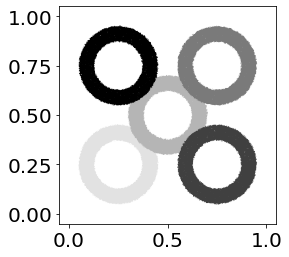

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 7min 31s, sys: 240 ms, total: 7min 31s
Wall time: 7min 40s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,4.358659,-1.310166
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.825120,0.790394
2,0.423655,0.645894,2,0,-8.459924,-5.952339,2.507585,0,-3.087031,5.372893
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639,0,1.025061,2.013020
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140,0,1.835574,7.972403


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        1.008836  1.018155  1.099101  0.009319  0.090266
            1        1.012592  0.928290  1.104562 -0.084302  0.091970
          1 0        0.003310  1.006678  0.967730  1.003369  0.964420
            1       -0.173538  0.893533  0.997216  1.067071  1.170754
          2 0       -0.078116  2.021561  1.911274  2.099677  1.989389
            1        0.042466  2.265625  1.864918  2.223159  1.822452
          3 0       -0.147834  3.059299  2.867251  3.207133  3.015085
            1        0.079238  3.061642  2.926226  2.982403  2.846988
          4 0        0.069275  3.963876  3.559792  3.894601  3.490517
            1       -0.112295  3.991634  3.560570  4.103929  3.672865
          5 0       -0.088802  4.995659  4.643408  5.084460  4.732210
            1        0.106705  5.126363  4.671905  5.019658  4.565199
1         0 0        0.993027  1.027382  0.905087 -0.034355  0.087941
            1        1.039488  0.960751  0.899246  0.078737  0.140241
          1 0        0.949874 -0.051025  0.173255  1.000899  0.776619
            1        0.959397  0.039923  0.029207  0.919474  0.930190
          2 0        2.003741  0.073958  0.070918  1.929783  1.932823
            1        2.069413  0.118261  0.086789  1.951152  1.982624
          3 0        3.066162  0.032472  0.008227  3.033690  3.057935
            1        3.105856  0.134903  0.016989  2.970953  3.088867
          4 0        3.869074 -0.074338  0.192695  3.943412  3.676379
            1        3.949477 -0.038362  0.239021  3.987839  3.710456
          5 0        5.004036 -0.007693  0.081478  5.011729  4.922558
            1        5.187981  0.077396  0.118837  5.110584  5.069144

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 2h 2min 40s, sys: 23.6 s, total: 2h 3min 3s
Wall time: 4min 5s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,4.358659,-1.310166,326,418
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.825120,0.790394,243,384
2,0.423655,0.645894,2,0,-8.459924,-5.952339,2.507585,0,-3.087031,5.372893,281,430
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639,0,1.025061,2.013020,387,61
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140,0,1.835574,7.972403,188,437


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.517013,491.0,1.0,0.002455
1,1,0.148158,450.0,1.0,0.002250
2,2,-0.008608,450.0,1.0,0.002250


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


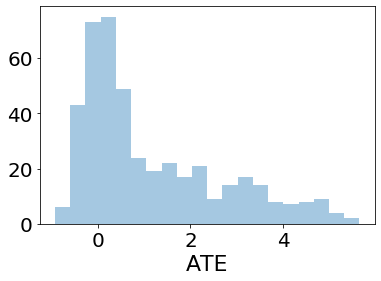

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 20
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


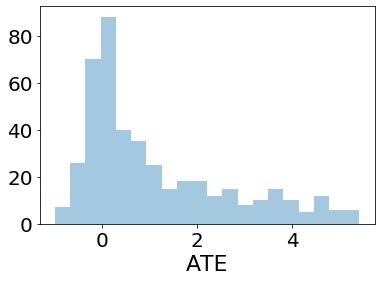

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], 
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


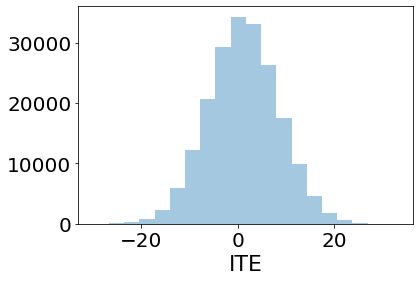

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,1.144772,453.514739,0.892414,0.002268
std,127.44999,1.515635,21.551110,0.154187,0.000108
min,0.00000,-0.925256,399.000000,0.447727,0.001995
25%,110.00000,-0.000884,439.000000,0.809417,0.002195
50%,220.00000,0.491336,453.000000,1.000000,0.002265
75%,330.00000,2.066469,468.000000,1.000000,0.002340
max,440.00000,5.653525,520.000000,1.000000,0.002600


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


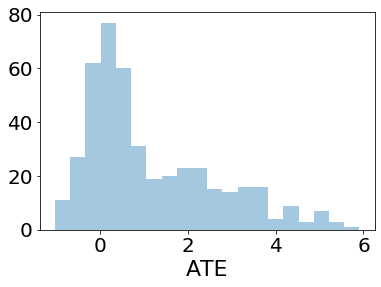

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


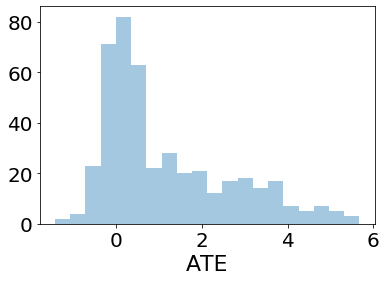

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-1,2.5)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


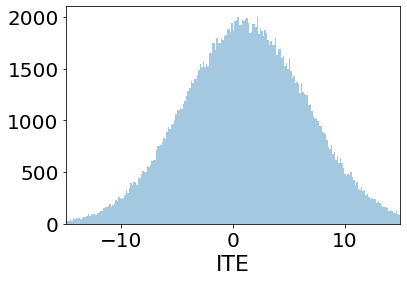

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 7
val = 6
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N, val = val )
    


Did not pick 6, it picked: 5
Did not pick 6, it picked: 5
CPU times: user 876 ms, sys: 94.3 ms, total: 970 ms
Wall time: 1.2 s


In [34]:
box['Box-Cl2'].value_counts()

1    133
0    114
2     61
4     50
3     50
5     33
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.517013,491.0,1.0,0.002455,0
1,1,0.148158,450.0,1.0,0.002250,1


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,4.358659,-1.310166,326,418
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.825120,0.790394,243,384


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5
filt41 = data2[col1] >= 2.5
filt51 = data2[col1] >= 3.5
filt61 = data2[col1] >= 4.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2
data2.loc[filt41,cluster_name1] = 3
data2.loc[filt51, cluster_name1] = 4
data2.loc[filt61, cluster_name1] = 5

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5
filt42 = data2[col2] >= 2.5
filt52 = data2[col2] >= 3.5
filt62 = data2[col2] >= 4.5


data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2
data2.loc[filt42,cluster_name2] = 3
data2.loc[filt52, cluster_name2] = 4
data2.loc[filt62, cluster_name2] = 5


#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,4.358659,-1.310166,326,418,0,0,2,2,2,1
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.825120,0.790394,243,384,5,1,0,1,0,1


### Plot reconstruction of data

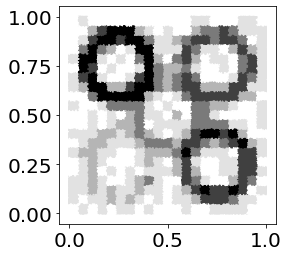

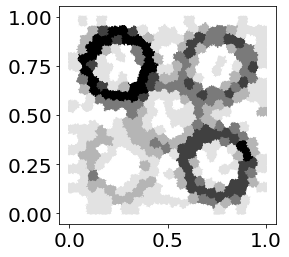

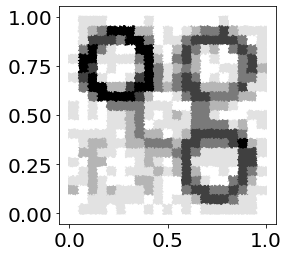

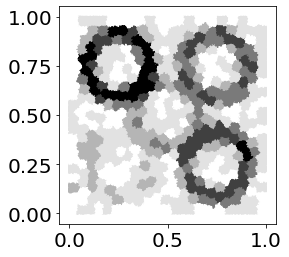

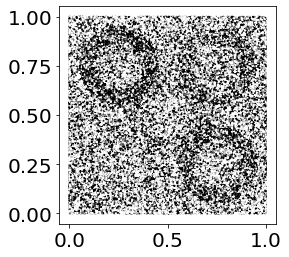

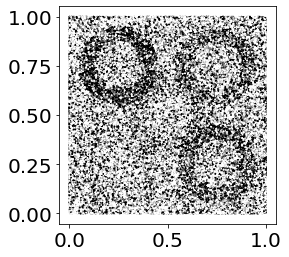

CPU times: user 1min 9s, sys: 1.61 s, total: 1min 11s
Wall time: 1min 9s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Kmeans-Cl2-err-GDBR,0.613143,0.723701
Kmeans2-Cl2-err-True-ITE,0.619955,0.746679
Kmeans-Cl2-err-True-ITE,0.628831,0.716080
Box-Cl2-err-GDBR,0.631304,0.743948
Box-Cl2-err-True-ITE,0.640777,0.740337
Box2-Cl2-err-True-ITE,0.648577,0.766030
Kmeans2-Cl2-err-GDBR,0.680388,0.710901
Box2-Cl2-err-GDBR,0.697938,0.737261
ITE-2CTrue-err-GDBR,2.920800,1.695486
ITE-2CGDBR-err-True-ITE,3.776216,1.981167


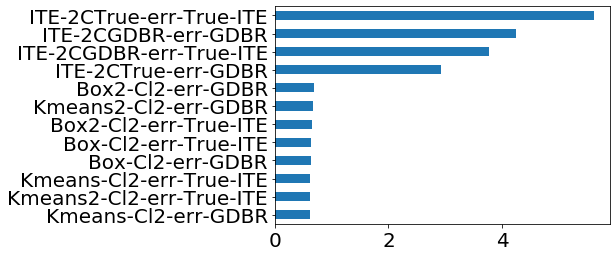

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 6, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.407389,0.417863,0.096654,0.052524,0.019814,0.005757
C1 True,0.013147,0.434467,0.523651,0.028734,0.000000,0.000000
C2 True,0.012319,0.035000,0.305050,0.598841,0.033695,0.015093
C3 True,0.001849,0.027919,0.125892,0.281425,0.562914,0.000000
C4 True,0.006351,0.013280,0.096683,0.134984,0.545005,0.203695
C5 True,0.000000,0.017102,0.049341,0.110907,0.134786,0.687864


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.473405,0.367412,0.105024,0.039881,0.010030,0.004249
C1 True,0.014435,0.440634,0.515587,0.029344,0.000000,0.000000
C2 True,0.002529,0.106062,0.448152,0.386636,0.056458,0.000163
C3 True,0.008032,0.023330,0.182815,0.493052,0.292772,0.000000
C4 True,0.005902,0.014371,0.125233,0.147302,0.649965,0.057227
C5 True,0.000000,0.025906,0.053268,0.098176,0.148721,0.673930


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.380769,0.420658,0.108462,0.070003,0.015351,0.004757
C1 True,0.066956,0.493697,0.438669,0.000678,0.000000,0.000000
C2 True,0.017867,0.048544,0.285959,0.598841,0.041364,0.007424
C3 True,0.001849,0.017976,0.126147,0.410314,0.443715,0.000000
C4 True,0.001668,0.017964,0.071406,0.253224,0.625521,0.030217
C5 True,0.004497,0.006904,0.045921,0.157145,0.169622,0.615911


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.389910,0.441226,0.105738,0.048847,0.011626,0.002652
C1 True,0.048726,0.515587,0.435687,0.000000,0.000000,0.000000
C2 True,0.008077,0.117810,0.460553,0.356041,0.046259,0.011259
C3 True,0.008032,0.023075,0.112251,0.480941,0.375701,0.000000
C4 True,0.004940,0.023609,0.091166,0.234105,0.588952,0.057227
C5 True,0.006271,0.012985,0.063403,0.119331,0.207119,0.590892


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.528636,0.056304,0.053747,0.052198,0.048831,0.260284
C1 True,0.469572,0.058756,0.057536,0.053809,0.053131,0.307197
C2 True,0.416334,0.055805,0.054418,0.057273,0.054826,0.361345
C3 True,0.354666,0.056540,0.057177,0.055584,0.053225,0.422807
C4 True,0.312632,0.051902,0.055495,0.057291,0.054918,0.467762
C5 True,0.259374,0.048138,0.051495,0.052002,0.056815,0.532176


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.529280,0.073838,0.069558,0.064587,0.056780,0.205958
C1 True,0.468894,0.078612,0.074004,0.068311,0.063567,0.246612
C2 True,0.390144,0.075467,0.078812,0.075467,0.070082,0.310027
C3 True,0.316548,0.071520,0.076428,0.074006,0.073942,0.387557
C4 True,0.279335,0.068262,0.071791,0.071213,0.074934,0.434465
C5 True,0.213453,0.056119,0.061946,0.067266,0.076831,0.524386


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.494439,0.488690,0.721079,0.499583,1.050950,1.129579,-3.174065,0.199418,1.031956,-3.701624,214.947089,219.307942,0.898210,1.400176,1.270398,1.393157,1.319936,0.570759,0.551513,0.647502,0.628170,2.714196,4.422703,0.587800,0.579083,0.590781,0.558502,5.313553,3.895143
1,0.498497,0.495447,1.041992,0.501557,1.176355,1.068260,1.012652,0.204012,1.172826,0.999663,217.930612,218.989415,1.960636,1.671602,1.536077,1.662539,1.589208,0.622443,0.607592,0.696507,0.680830,2.986090,1.328371,0.634024,0.625419,0.646910,0.620646,5.437360,1.334123
2,0.506232,0.499266,1.132785,0.503933,1.203367,1.222185,1.863431,0.201516,1.187670,2.001679,219.831645,219.922270,2.272019,1.750159,1.613406,1.734358,1.662793,0.631862,0.626113,0.702063,0.694972,3.026571,1.770965,0.641625,0.642683,0.653473,0.637180,5.502047,1.715986
3,0.503862,0.498187,1.200911,0.506829,1.239559,1.173931,2.778760,0.202403,1.196277,2.993986,219.383760,218.743787,2.594447,1.799612,1.661915,1.785432,1.711322,0.638024,0.627215,0.708098,0.693505,3.084679,2.278790,0.647374,0.641054,0.661324,0.635902,5.588128,2.170639
4,0.501153,0.503994,1.351137,0.515215,1.323086,1.246343,3.657944,0.195788,1.204179,3.991901,221.638133,219.833680,2.911435,1.924407,1.775785,1.903908,1.820628,0.670691,0.646616,0.732064,0.706902,3.148100,2.838119,0.676529,0.655932,0.687527,0.651342,5.754490,2.631509
5,0.506072,0.517377,1.797303,0.500725,1.397848,1.367928,7.212957,0.199890,1.411567,7.949421,227.706687,221.185855,3.900046,2.271480,2.123548,2.242326,2.167948,0.723962,0.703068,0.771176,0.754415,3.128824,6.152118,0.721023,0.700030,0.732229,0.706846,6.158241,5.415654


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(4.258764719574937, 3.230896078226727)